In [1]:
from obspy import read, Stream,UTCDateTime
from glob import glob
import pandas as pd
from obspy.taup import TauPyModel
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
from datetime import timezone
import datetime

import matplotlib.patches as patches
import matplotlib.patheffects as path_effects

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np # For min, max, and other numerical operations
import cartopy.crs as ccrs
import cartopy.feature as cfeature


In [2]:
import enum

# Ground truth source names
class GtSource(enum.Enum):
  __order__ = 'ANY ISC INVESTIGATIVE USGS JMA ANDROID CSN_UCHILE'
  ANY = 0
  ISC = 1
  INVESTIGATIVE = 2
  USGS = 3
  JMA = 4
  ANDROID = 5
  CSN_UCHILE = 6

    
print(GtSource['ANDROID'].value)

5


Index(['Code', 'Longitude', 'Latitude', 'Province', 'District', 'PGA_NS',
       'PGA_EW', 'PGA_UD', 'Rjb', 'Rrup', 'Repi', 'Rhyp'],
      dtype='object')


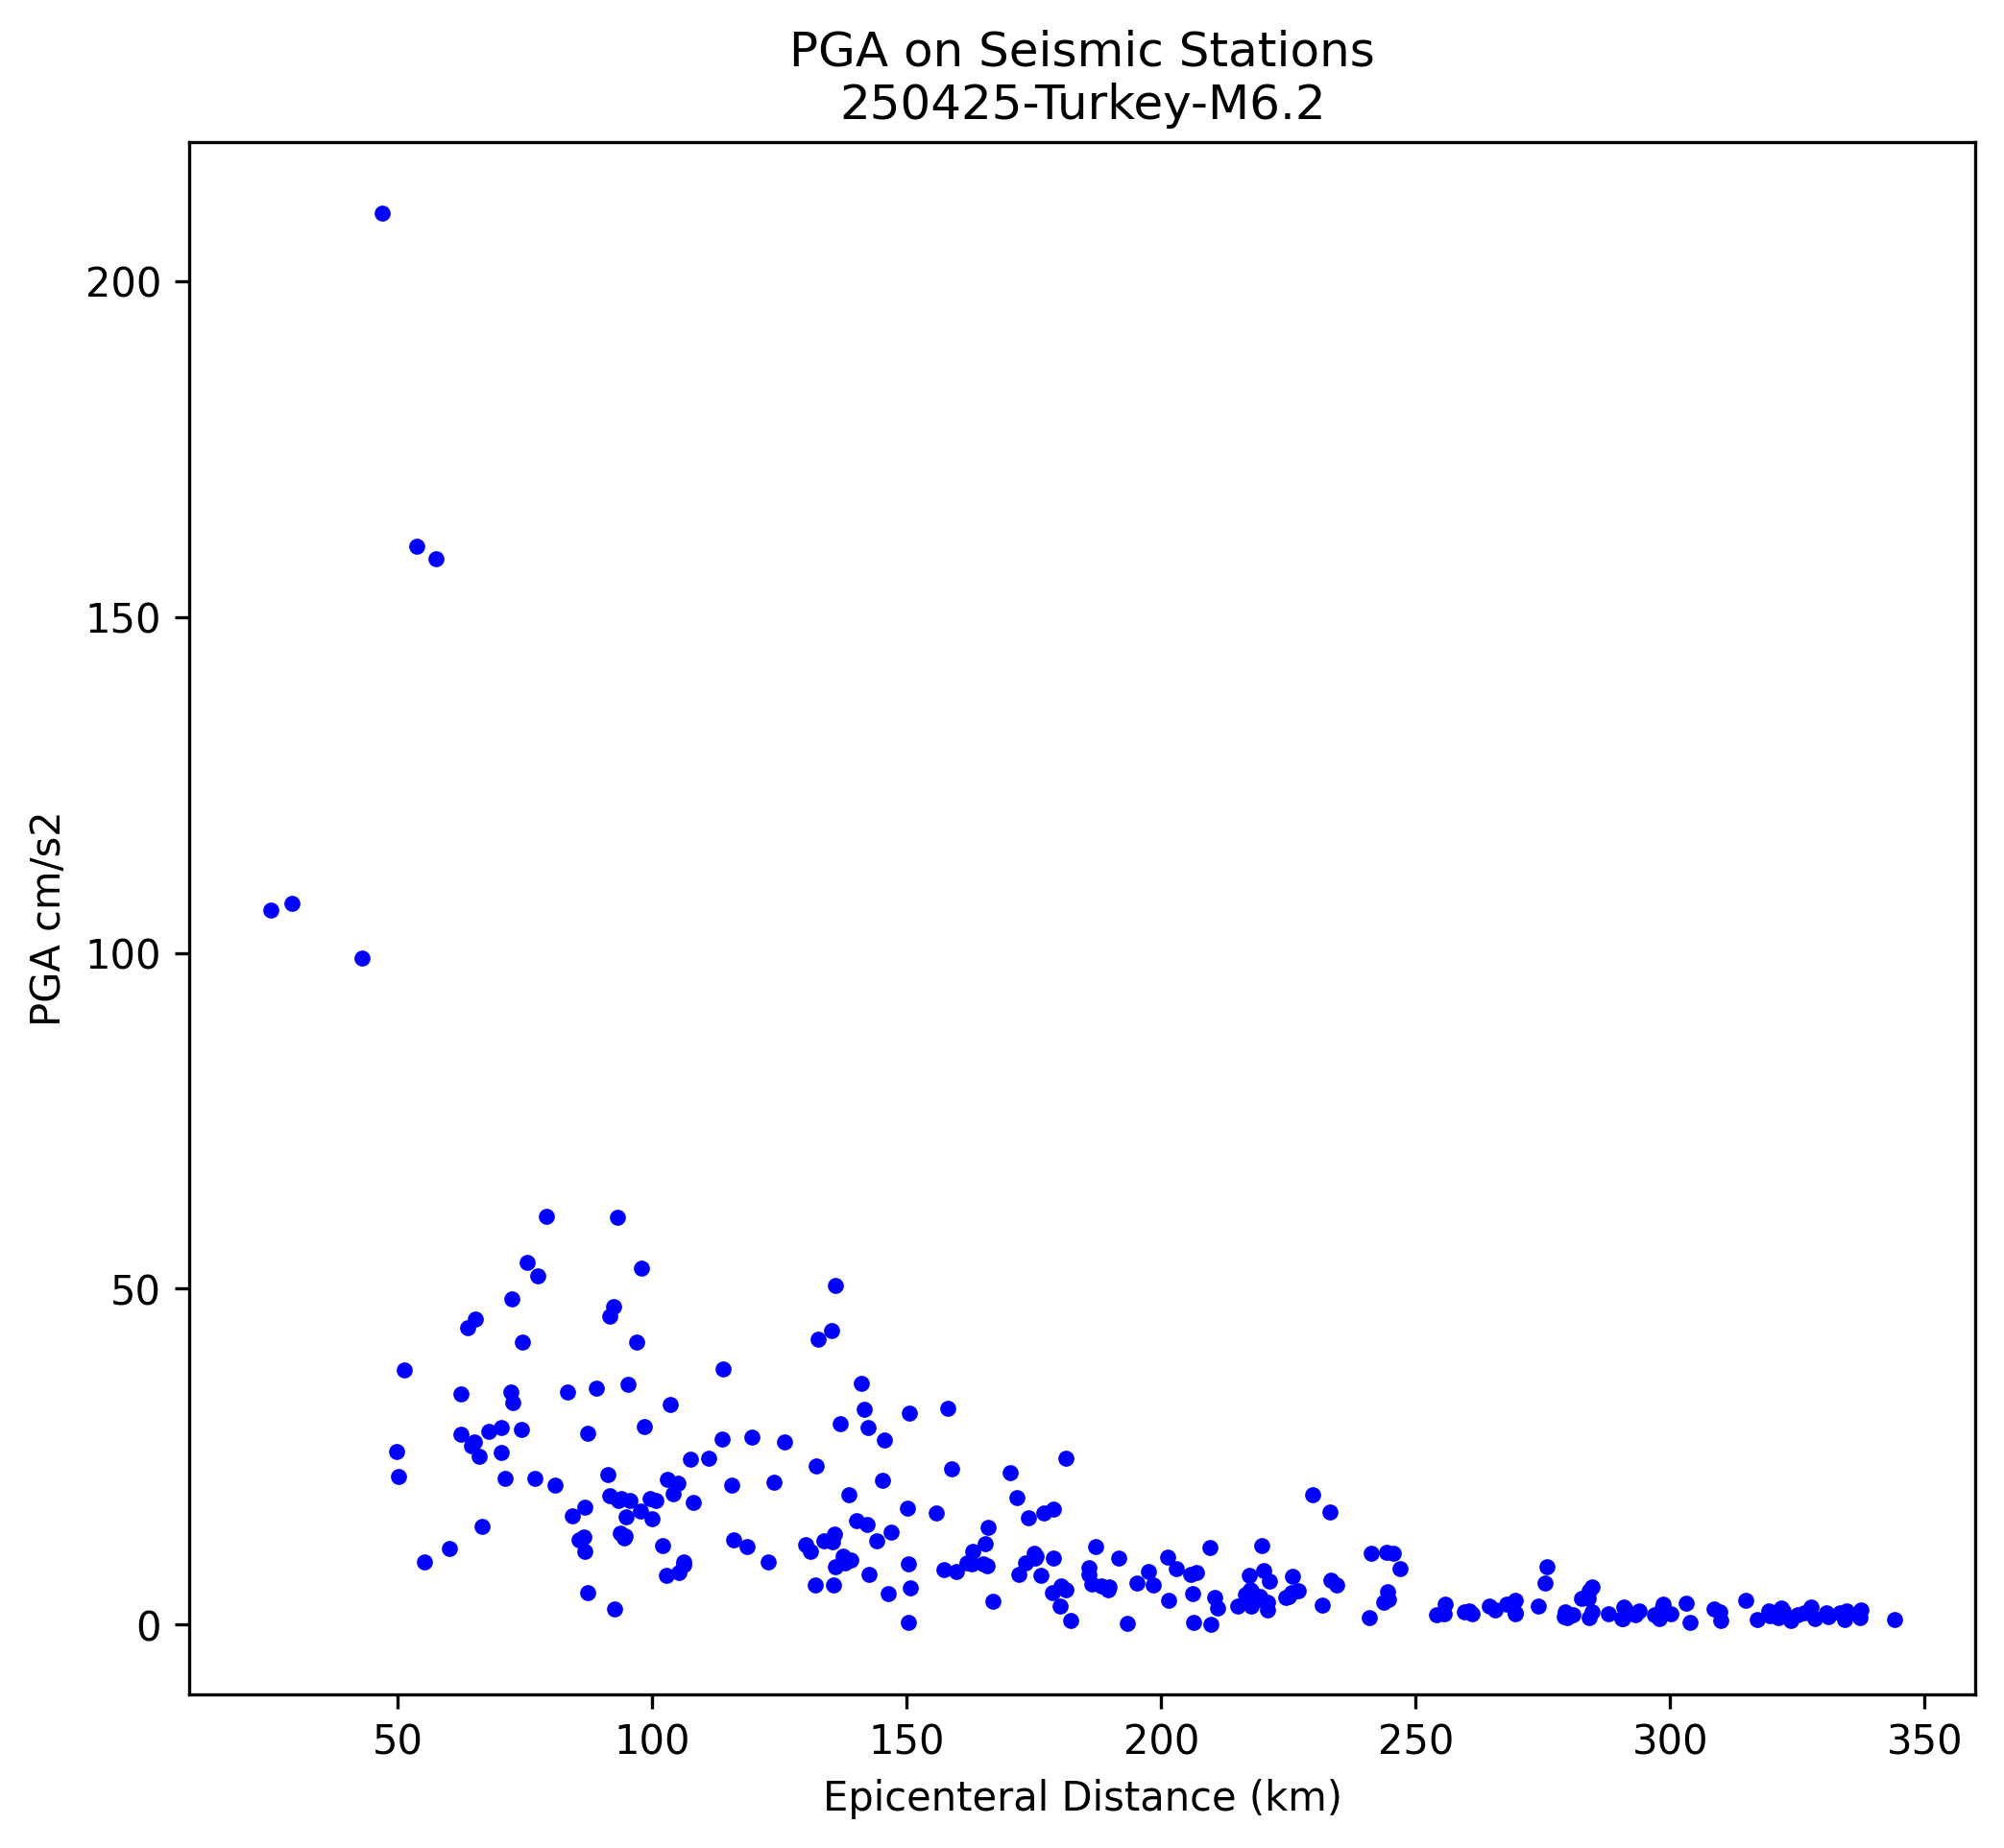

Index(['Code', 'Longitude', 'Latitude', 'Province', 'District', 'PGA_NS',
       'PGA_EW', 'PGA_UD', 'Rjb', 'Rrup', 'Repi', 'Rhyp'],
      dtype='object')


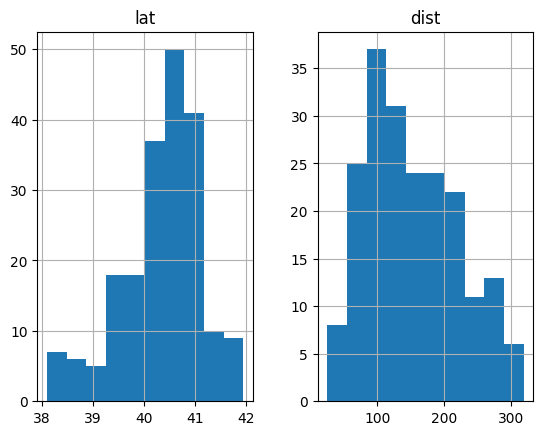

In [3]:
## Station data from Turkey network -- PROCERSSED DATA
proccessed_station_df = pd.read_csv('data_turkey_m6_25.csv')
print(proccessed_station_df.keys())

columns_for_max = ['PGA_NS', 'PGA_EW', 'PGA_UD']
proccessed_station_df['max_value_of_xyz'] = proccessed_station_df[columns_for_max].max(axis=1)

fig = plt.figure(figsize = (8,7), dpi=300)
ax = fig.add_subplot(1, 1, 1)
ax.plot(proccessed_station_df.Repi, proccessed_station_df.max_value_of_xyz, 'bo', label = 'PGA', markersize=3)
ax.set_xlabel('Epicenteral Distance (km)')
ax.set_ylabel('PGA cm/s2')
ax.set_title('PGA on Seismic Stations\n' '250425-Turkey-M6.2')

plt.show()



## Seismic Station Waveform Data
## Coverting data into csv for Colab reading
data_dict = {'station': [],
             'lat': [],
             'lng': [],
             'dist': [],
             'data_z': [],
             'data_n': [],
             'data_e': [],
             'start_time_utc': [],
             'end_time_utc': [],
             'sampling_rate': [],
             'delta': [],
             'npts': [],
             'PGA_NS': [],
             'PGA_EW': [],
             'PGA_UD': [],
             'Rjb': [],
             'Rrup': [],
             'Rhyp': []
            }

df = pd.read_csv('data_turkey_m6_25.csv')
print(df.keys())
all_z_data = glob("./data_m6_4_25/data/*mseed")

for trdata in all_z_data:
    tr = read(trdata)
    station_code = tr[0].stats.station
    try:

        lng = df[df["Code"] == station_code].Longitude.values[0]
        lat = df[df["Code"] == station_code].Latitude.values[0]
        dist = df[df["Code"] == station_code]["Repi"].values[0]
        zc = tr.select(component="Z")
        ec = tr.select(component="E")
        nc = tr.select(component="N")

        if len(tr[0].data) > 1000:
            data_dict['station'].append(station_code)
            data_dict['lat'].append(lat)
            data_dict['lng'].append(lng)
            data_dict['dist'].append(dist)
            data_dict['data_z'].append(zc[0].data.tolist())
            data_dict['data_e'].append(ec[0].data.tolist())
            data_dict['data_n'].append(nc[0].data.tolist())
            data_dict['start_time_utc'].append(tr[0].stats.starttime)
            data_dict['end_time_utc'].append(tr[0].stats.endtime)
            data_dict['sampling_rate'].append(tr[0].stats.sampling_rate)
            data_dict['delta'].append(tr[0].stats.delta)
            data_dict['npts'].append(tr[0].stats.npts)
            data_dict['PGA_NS'].append(df[df["Code"] == station_code]["PGA_NS"].values[0])
            data_dict['PGA_EW'].append(df[df["Code"] == station_code]["PGA_EW"].values[0])
            data_dict['PGA_UD'].append(df[df["Code"] == station_code]["PGA_UD"].values[0])
            data_dict['Rjb'].append(df[df["Code"] == station_code]["Rjb"].values[0])
            data_dict['Rrup'].append(df[df["Code"] == station_code]["Rrup"].values[0])
            data_dict['Rhyp'].append(df[df["Code"] == station_code]["Rhyp"].values[0])
    except Exception:
        pass
         
station_df = pd.DataFrame(data_dict)
station_df.hist(column=['lat', 'dist'])
station_df.to_csv('turkish_data_2504.csv', index=False)

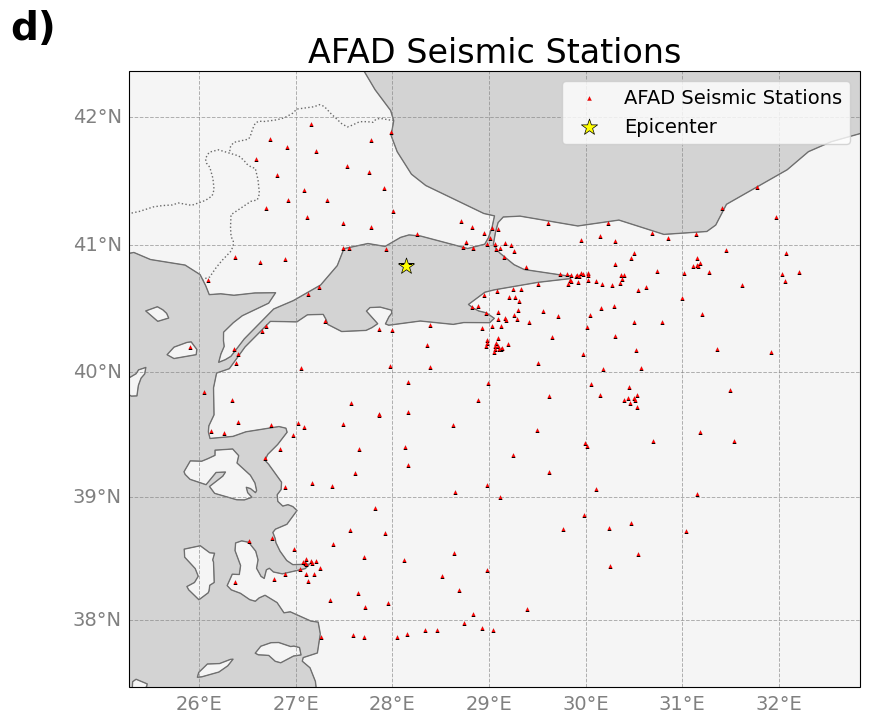

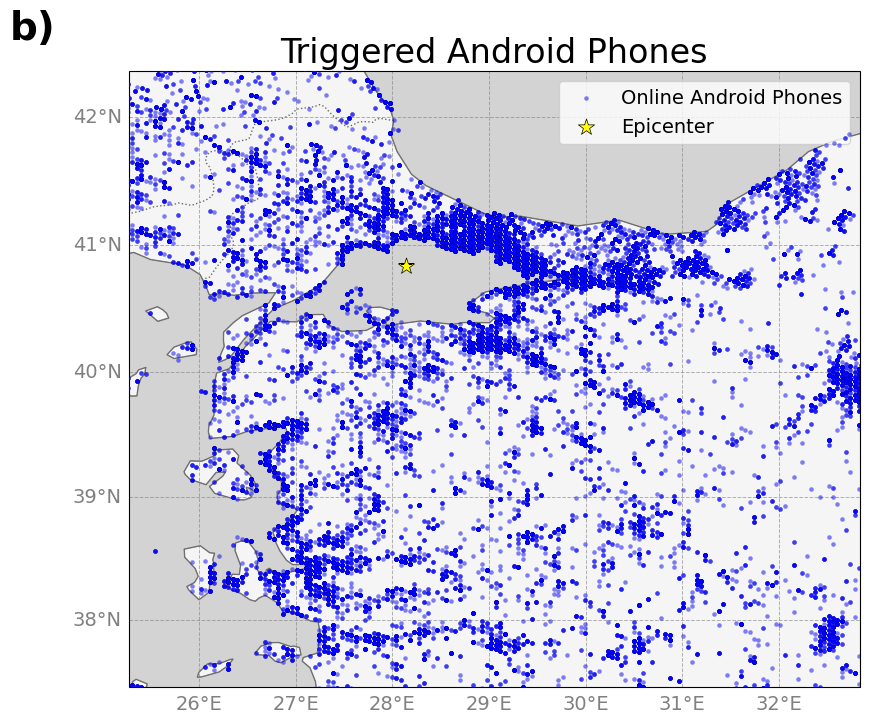

In [9]:
# Plotting stations and phone maps

lon_col_name = 'Longitude'
lat_col_name = 'Latitude'

new_coord_lat = 40.840
new_coord_lon = 28.142
star_size = 150 # Adjust size for visibility

lons = proccessed_station_df[lon_col_name].values
lats = proccessed_station_df[lat_col_name].values
sizes = 10

# This is the CRS of your raw lat/lon data
data_crs = ccrs.PlateCarree()


# Step 3: Create the Map and Plot Coordinates
fig = plt.figure(figsize=(12, 8)) # Adjust figure size as needed

# Choose a projection for your map
projection = ccrs.Mercator() # Mercator is often good for zooming into regions
# projection = ccrs.PlateCarree() # Another option

ax = fig.add_subplot(1, 1, 1, projection=projection)

# Add map features
# ax.add_feature(cfeature.LAND.with_scale('50m'), facecolor='gainsboro', edgecolor='gray')
# ax.add_feature(cfeature.OCEAN.with_scale('50m'), facecolor='aliceblue')
# Set a gray color for the ocean
ax.add_feature(cfeature.OCEAN.with_scale('50m'), facecolor='lightgray', zorder=0)

# Set a white or off-white color for the land
ax.add_feature(cfeature.LAND.with_scale('50m'), facecolor='whitesmoke', edgecolor='gray', zorder=0)

# You can keep the coastline for a defined border
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), edgecolor='dimgray', linewidth=0.5, zorder=1)
ax.add_feature(cfeature.BORDERS.with_scale('50m'), linestyle=':', edgecolor='dimgray')
# ax.add_feature(cfeature.LAKES.with_scale('50m'), facecolor='aliceblue', edgecolor='dimgray')
# ax.add_feature(cfeature.RIVERS.with_scale('50m'), edgecolor='lightblue')
# Plot your coordinates

# Plot your coordinates
ax.scatter(lons, lats,
           s=sizes,
           marker= "^",
           color='red',
           alpha=1,
           edgecolors='black',
           linewidth=0.05,
           transform=data_crs, # Crucial: specify data CRS
           label='AFAD Seismic Stations',
           zorder=10)

ax.scatter(new_coord_lon, new_coord_lat,
           s=star_size, # Increased size for visibility
           marker='*', # Star marker
           color='yellow',
           edgecolors='black', # Optional: add a black outline
           linewidth=0.5,
           transform=data_crs,
           label='Epicenter',
           zorder=11) # Ensure it's on top of other features


# Step 4: Customize the map - SET EXTENT BASED ON DATA
if lons.size > 0 and lats.size > 0:  # Check if there are any points to plot
    # Calculate min and max for longitude and latitude
    min_lon, max_lon = np.min(lons), np.max(lons)
    min_lat, max_lat = np.min(lats), np.max(lats)

    # Add some padding (e.g., 10% of the range)
    lon_padding = (max_lon - min_lon) * 0.10
    lat_padding = (max_lat - min_lat) * 0.10

    # Handle cases where all points have the same lat/lon (range is 0)
    if lon_padding == 0:
        lon_padding = 1  # Default padding in degrees (e.g., 1 degree)
    if lat_padding == 0:
        lat_padding = 1  # Default padding in degrees

    # Define the extent with padding
    extent = [
        min_lon - lon_padding,
        max_lon + lon_padding,
        min_lat - lat_padding,
        max_lat + lat_padding
    ]

    # Clip extent to valid lat/lon ranges if necessary
    # (e.g., latitudes -90 to 90, longitudes -180 to 180,
    # though Cartopy often handles longitude wrapping for global views).
    # For regional views, this basic clipping is usually fine.
    extent[0] = max(extent[0], -180) # min_lon
    extent[1] = min(extent[1], 180)  # max_lon
    extent[2] = max(extent[2], -90)  # min_lat
    extent[3] = min(extent[3], 90)   # max_lat


    # Set the map extent
    ax.set_extent(extent, crs=data_crs)
else:
    # If no data, you might want a default view (e.g., global)
    ax.set_global()


# Add gridlines and labels
try:
    gl = ax.gridlines(crs=data_crs, draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.6, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size':14, 'color': 'gray'}
    gl.ylabel_style = {'size':14, 'color': 'gray'}
    
except Exception as e:
    print(f"Could not draw gridline labels: {e}")
    ax.gridlines(crs=data_crs, linewidth=0.7, color='gray', alpha=0.6, linestyle='--')

ax.text(-0.1, 1.1, 'd)', transform=ax.transAxes, fontsize=28, fontweight='bold', va='top', ha='right')
ax.legend(fontsize=14)

plt.title("AFAD Seismic Stations", fontsize=24)

plt.show()
fig.savefig('map_seismic_stations.png',dpi=500)





In [4]:
# Computing PGAs 
import glob

station_proccessed_df = pd.read_csv('data_turkey_m6_25.csv')
all_z_data = glob.glob("./data_m6_4_25/data/*mseed")

start = UTCDateTime("2025-04-23T09:49:10.00")
end = UTCDateTime("2025-04-23T09:51:40.00")

from obspy import UTCDateTime

PGA_THRESHOLD_MMI3_cms2 = 2.91# for MMI3 0.297 %g
PGA_THRESHOLD_MMI5_cms2 = 60 # for MMI5 6.2 %g

dist_pga_time_mmi3 = []
dist_pga_time_mmi5 = []

for trdata in all_z_data:
    tr = read(trdata)
    all_channels_pga = []
    for i in range(3):
        station_code = tr[i].stats.station
        try:
            lng = station_proccessed_df[station_proccessed_df["Code"] == int(station_code)].Longitude.values[0]
            lat = station_proccessed_df[station_proccessed_df["Code"] == int(station_code)].Latitude.values[0]
            dist = station_proccessed_df[station_proccessed_df["Code"] == int(station_code)]["Repi"].values[0]
        except:
            lng = station_proccessed_df[station_proccessed_df["Code"] == station_code].Longitude.values[0]
            lat = station_proccessed_df[station_proccessed_df["Code"] == station_code].Latitude.values[0]
            dist = station_proccessed_df[station_proccessed_df["Code"] == station_code]["Repi"].values[0]
            
        tr[i].detrend("spline", order=3, dspline=500)
       # tr[i].filter("bandpass", freqmin = 0.5, freqmax = 5, corners=1, zerophase=True)
        tr.trim(start, end, pad=True, fill_value=0)
        passed_threshold = None
        for acc, time in zip(tr[i].data, tr[i].times()):
            if abs(acc) >= PGA_THRESHOLD_MMI3_cms2:
                passed_threshold = (abs(acc), float(time))
                break
        if passed_threshold:      
            all_channels_pga.append(passed_threshold)
    if len(all_channels_pga) >= 1: 
        pga_3c, pga_time = min(all_channels_pga, key=lambda item: item[1])
        dist_pga_time_mmi3.append((dist, pga_3c, pga_time))

for trdata in all_z_data:
    tr = read(trdata)
    all_channels_pga = []
    for i in range(3):
        station_code = tr[i].stats.station
        try:
            lng = station_proccessed_df[station_proccessed_df["Code"] == int(station_code)].Longitude.values[0]
            lat = station_proccessed_df[station_proccessed_df["Code"] == int(station_code)].Latitude.values[0]
            dist = station_proccessed_df[station_proccessed_df["Code"] == int(station_code)]["Repi"].values[0]
        except:
            lng = station_proccessed_df[station_proccessed_df["Code"] == station_code].Longitude.values[0]
            lat = station_proccessed_df[station_proccessed_df["Code"] == station_code].Latitude.values[0]
            dist = station_proccessed_df[station_proccessed_df["Code"] == station_code]["Repi"].values[0]
            
        tr[i].detrend("spline", order=3, dspline=500)
        tr[i].filter("bandpass", freqmin = 0.5, freqmax = 5, corners=1, zerophase=True)
        tr.trim(start, end, pad=True, fill_value=0)
        channel = tr[i].stats.channel
            
        passed_threshold = None
        for acc, time in zip(tr[i].data, tr[i].times()):
            if abs(acc) >= PGA_THRESHOLD_MMI5_cms2:
                passed_threshold = (abs(acc), float(time))
                break
        if passed_threshold:      
            all_channels_pga.append(passed_threshold)
    if len(all_channels_pga) >= 1: 
        pga_3c, pga_time = min(all_channels_pga, key=lambda item: item[1])
        dist_pga_time_mmi5.append((dist, pga_3c, pga_time))

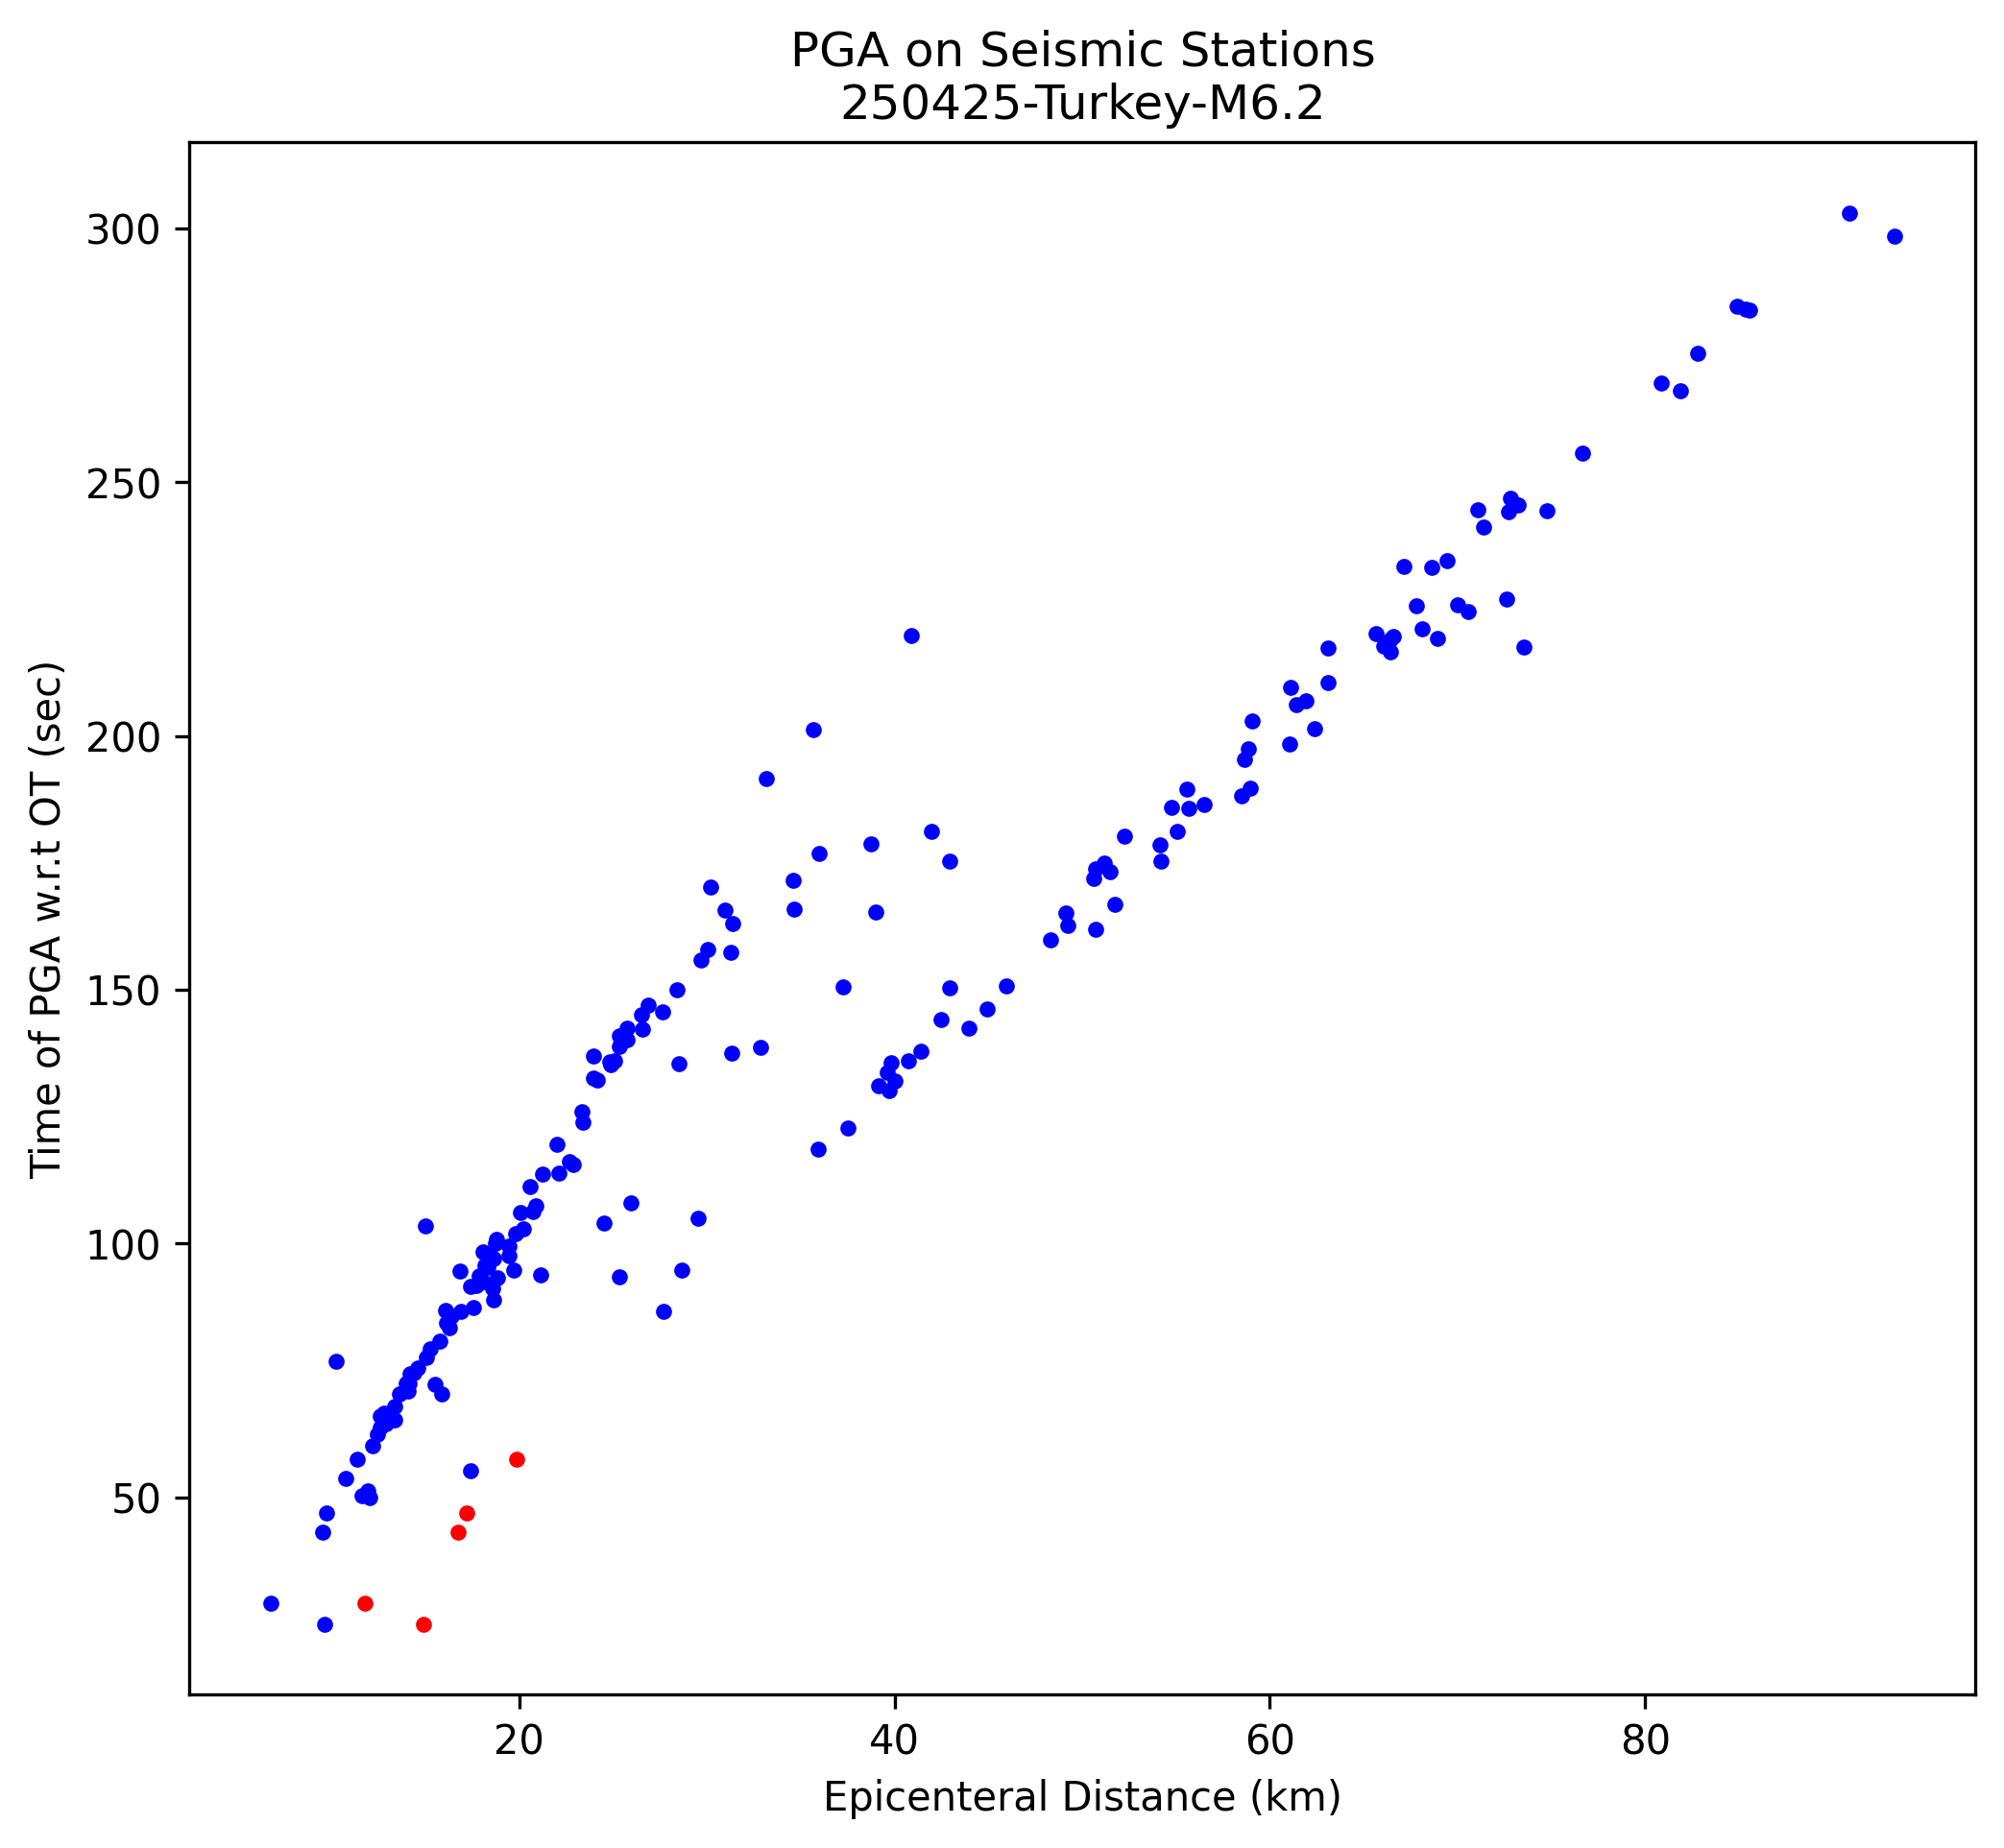

In [59]:
# MMI3, MMI5-PGA times vs Distance - Station data
p = 6.3
s = 3.5
dist_min = 0
dist_max = 400
ev_depth = 10

epi_dist = np.arange(0, dist_max)
hypo = np.sqrt(epi_dist**2+ev_depth**2)
travel_times = np.c_[epi_dist, hypo/p, hypo/s] 

fig = plt.figure(figsize = (8,7), dpi=300)
ax = fig.add_subplot(1, 1, 1)

ax.plot([time for _, _,time in dist_pga_time_mmi3], [dist for dist, _, _ in dist_pga_time_mmi3], 'bo', label = 'PGA', markersize=3)
ax.plot([time for _, _,time in dist_pga_time_mmi5], [dist for dist, _, _ in dist_pga_time_mmi5], 'ro', label = 'PGA', markersize=3)

ax.set_xlabel('Epicenteral Distance (km)')
ax.set_ylabel('Time of PGA w.r.t OT (sec)')
ax.set_title('PGA on Seismic Stations\n' '250425-Turkey-M6.2')
plt.show()


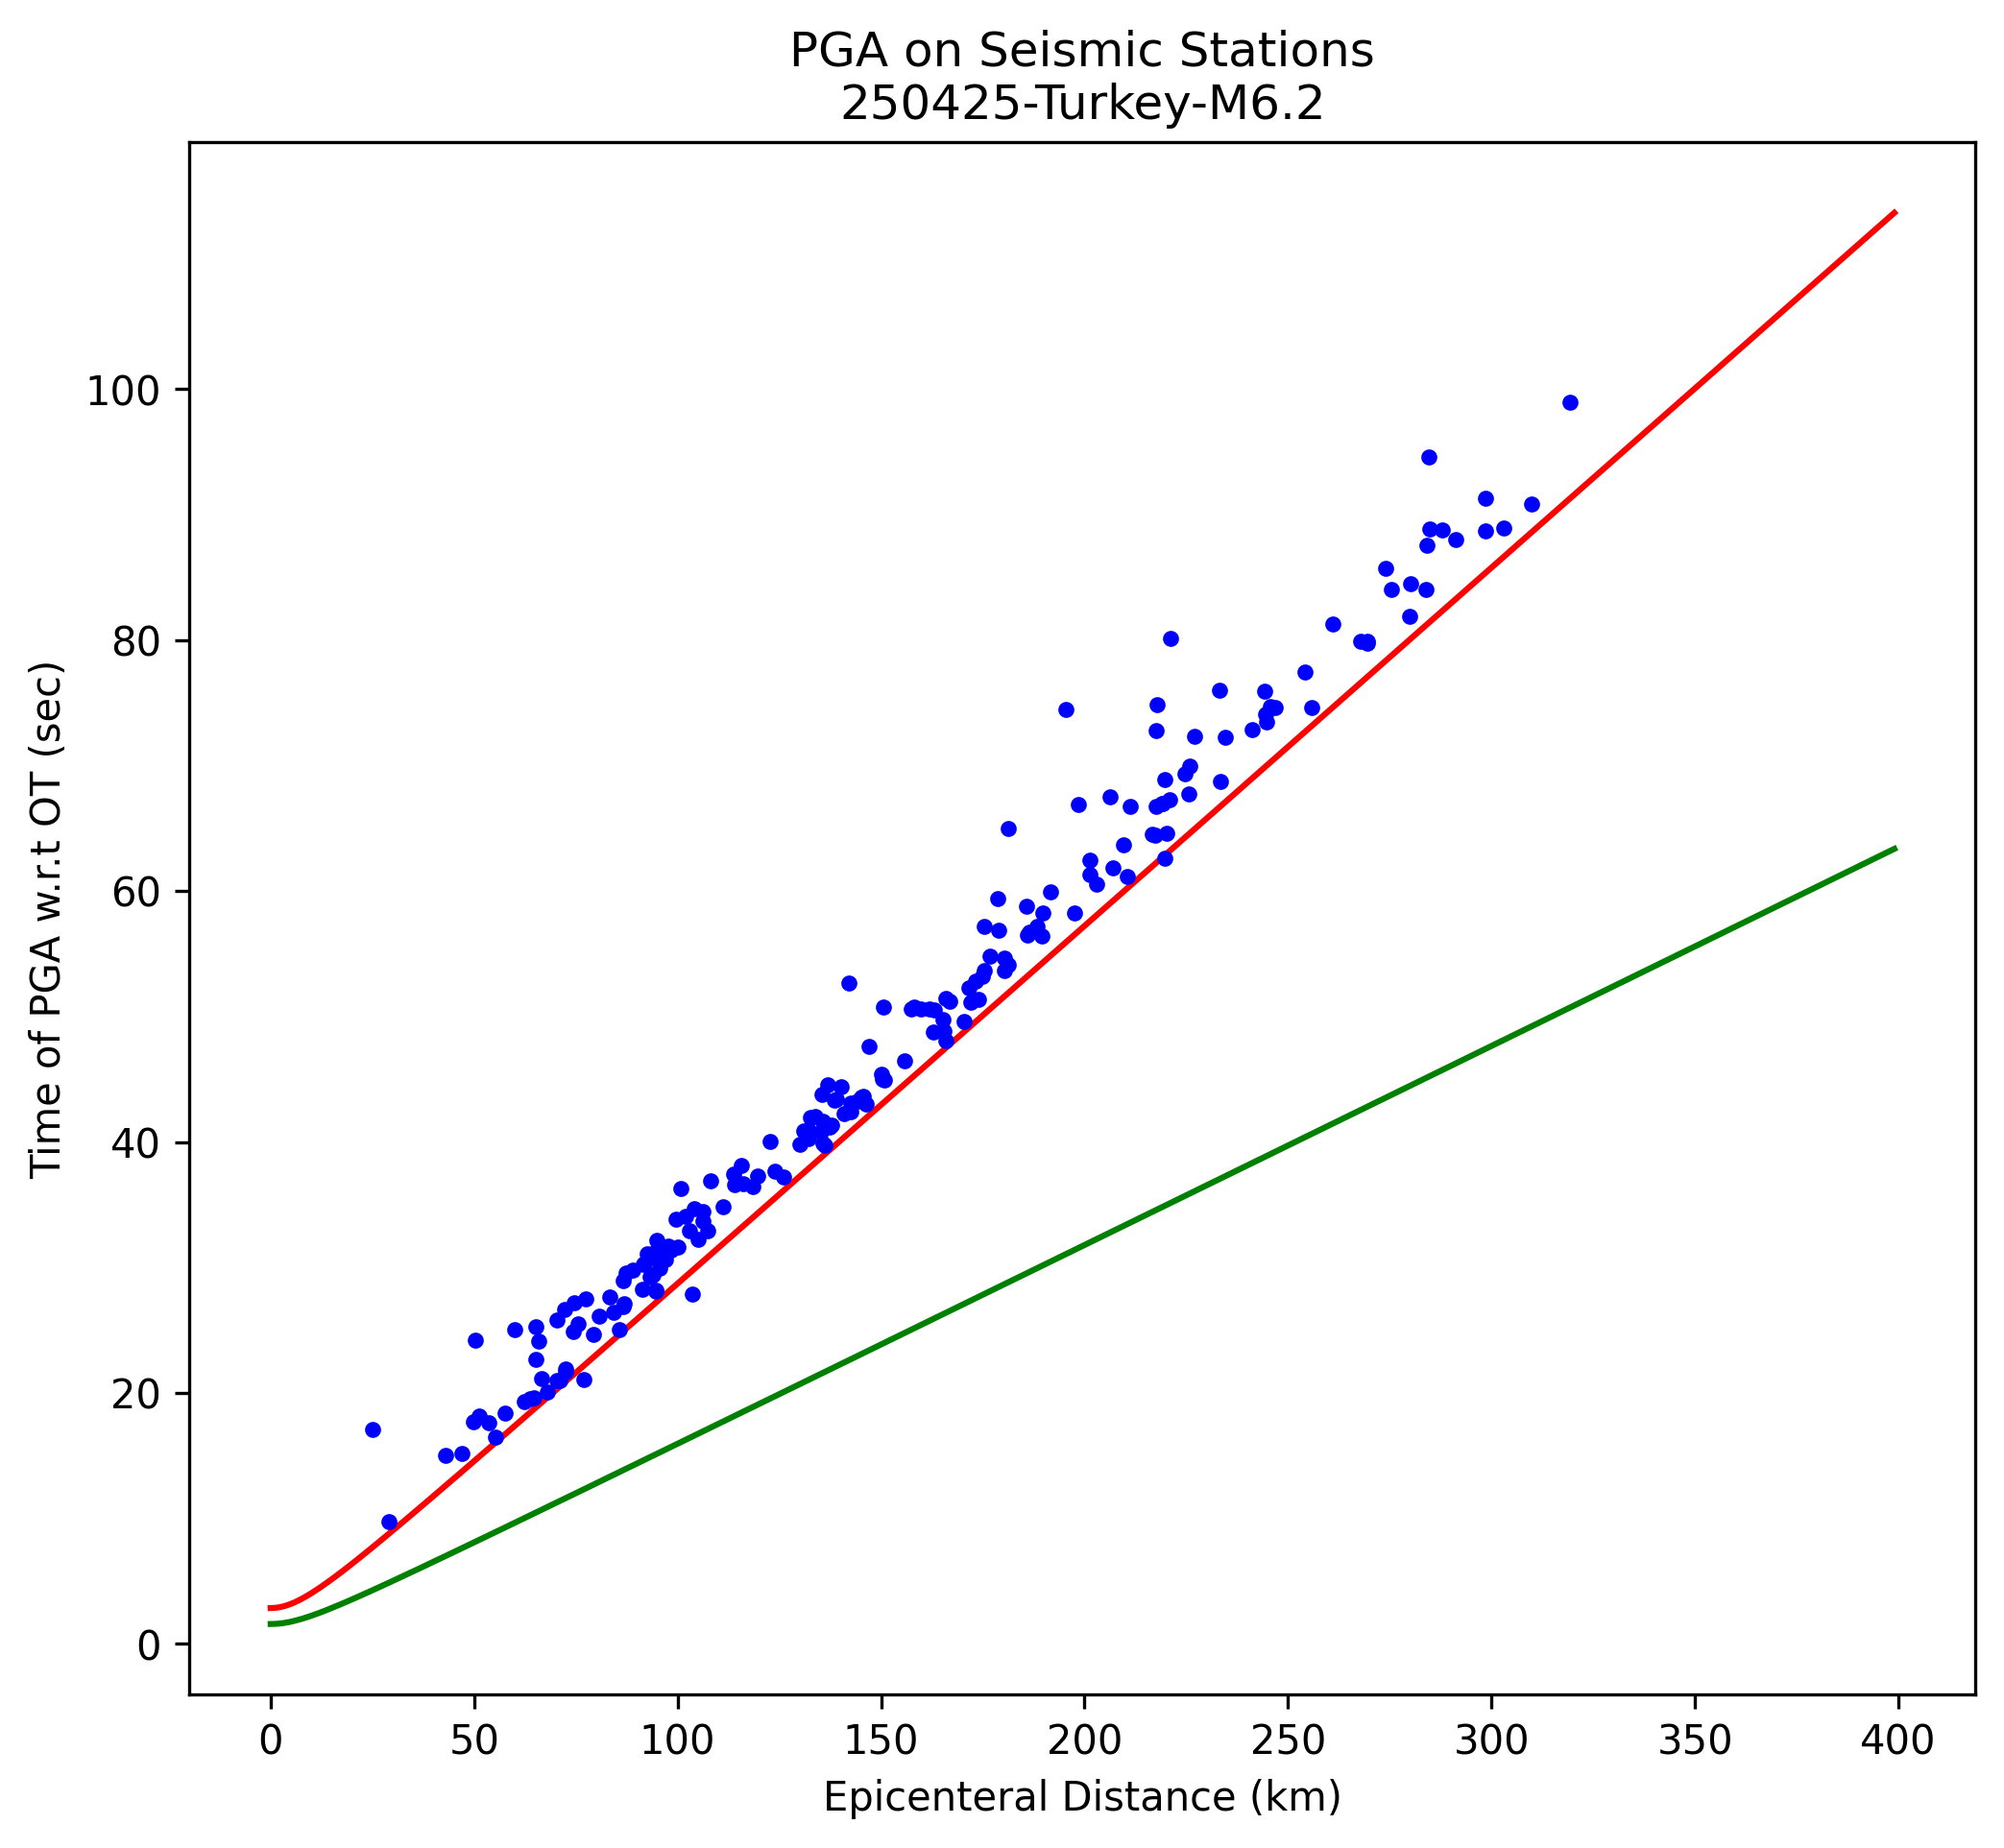

In [6]:
# PGA times vs Distance vs P&S arrival waves

df = pd.read_csv('data_turkey_m6_25.csv')
all_z_data = glob.glob("./data_m6_4_25/data/*mseed")

from obspy import UTCDateTime
origin_time = UTCDateTime(2025, 4, 23, 9, 49, 12, 00000)


stream = Stream()

accel_df = {'epi_dist_km': [],
           'pga_time_wrot': [],
           'pga': [],
           'lat': [],
           'lng': [],
           'station': [],
          }

for trdata in all_z_data:
    tr = read(trdata)
    all_channels_pga = []
    for i in range(3):
        channel = tr[i].stats.channel 
        st = tr[i].stats.starttime
        et = tr[i].stats.endtime
        delta_t = st - origin_time
        station_code = tr[i].stats.station
        try:
            lng = df[df["Code"] == int(station_code)].Longitude.values[0]
            lat = df[df["Code"] == int(station_code)].Latitude.values[0]
            dist = df[df["Code"] == int(station_code)]["Repi"].values[0]
        except:
            lng = df[df["Code"] == station_code].Longitude.values[0]
            lat = df[df["Code"] == station_code].Latitude.values[0]
            dist = df[df["Code"] == station_code]["Repi"].values[0]
            
        tr[i].detrend("spline", order=3, dspline=500)
        pga = tr[i].max()
        pga_idx = list(tr[i].data).index(pga)
        pga_t = list(tr[i].times())[pga_idx]
        pga_time_wrot = pga_t+delta_t
        all_channels_pga.append((abs(pga), pga_time_wrot))
        
    pga_3c, pga_time_wrot = max(all_channels_pga, key=lambda item: item[0])
    accel_df['station'].append(station_code)
    accel_df['epi_dist_km'].append(dist)
    accel_df['pga'].append(pga_3c)                
    accel_df['lng'].append(lng)
    accel_df['lat'].append(lat)
    accel_df['pga_time_wrot'].append(pga_time_wrot)

df_pga = pd.DataFrame(accel_df)

p = 6.3
s = 3.5
dist_min = 0
dist_max = 400
ev_depth = 10

epi_dist = np.arange(0, dist_max)
hypo = np.sqrt(epi_dist**2+ev_depth**2)
travel_times = np.c_[epi_dist, hypo/p, hypo/s] 

fig = plt.figure(figsize = (8,7), dpi=300)
ax = fig.add_subplot(1, 1, 1)
ax.plot(travel_times[:, 0], travel_times[:,1], 'g', label = 'Theoretical P')
ax.plot(travel_times[:, 0], travel_times[:,2], 'r', label = 'Theoretical s')

ax.plot(df_pga.epi_dist_km, df_pga.pga_time_wrot, 'bo', label = 'PGA', markersize=3)
ax.set_xlabel('Epicenteral Distance (km)')
ax.set_ylabel('Time of PGA w.r.t OT (sec)')
ax.set_title('PGA on Seismic Stations\n' '250425-Turkey-M6.2')
plt.show()

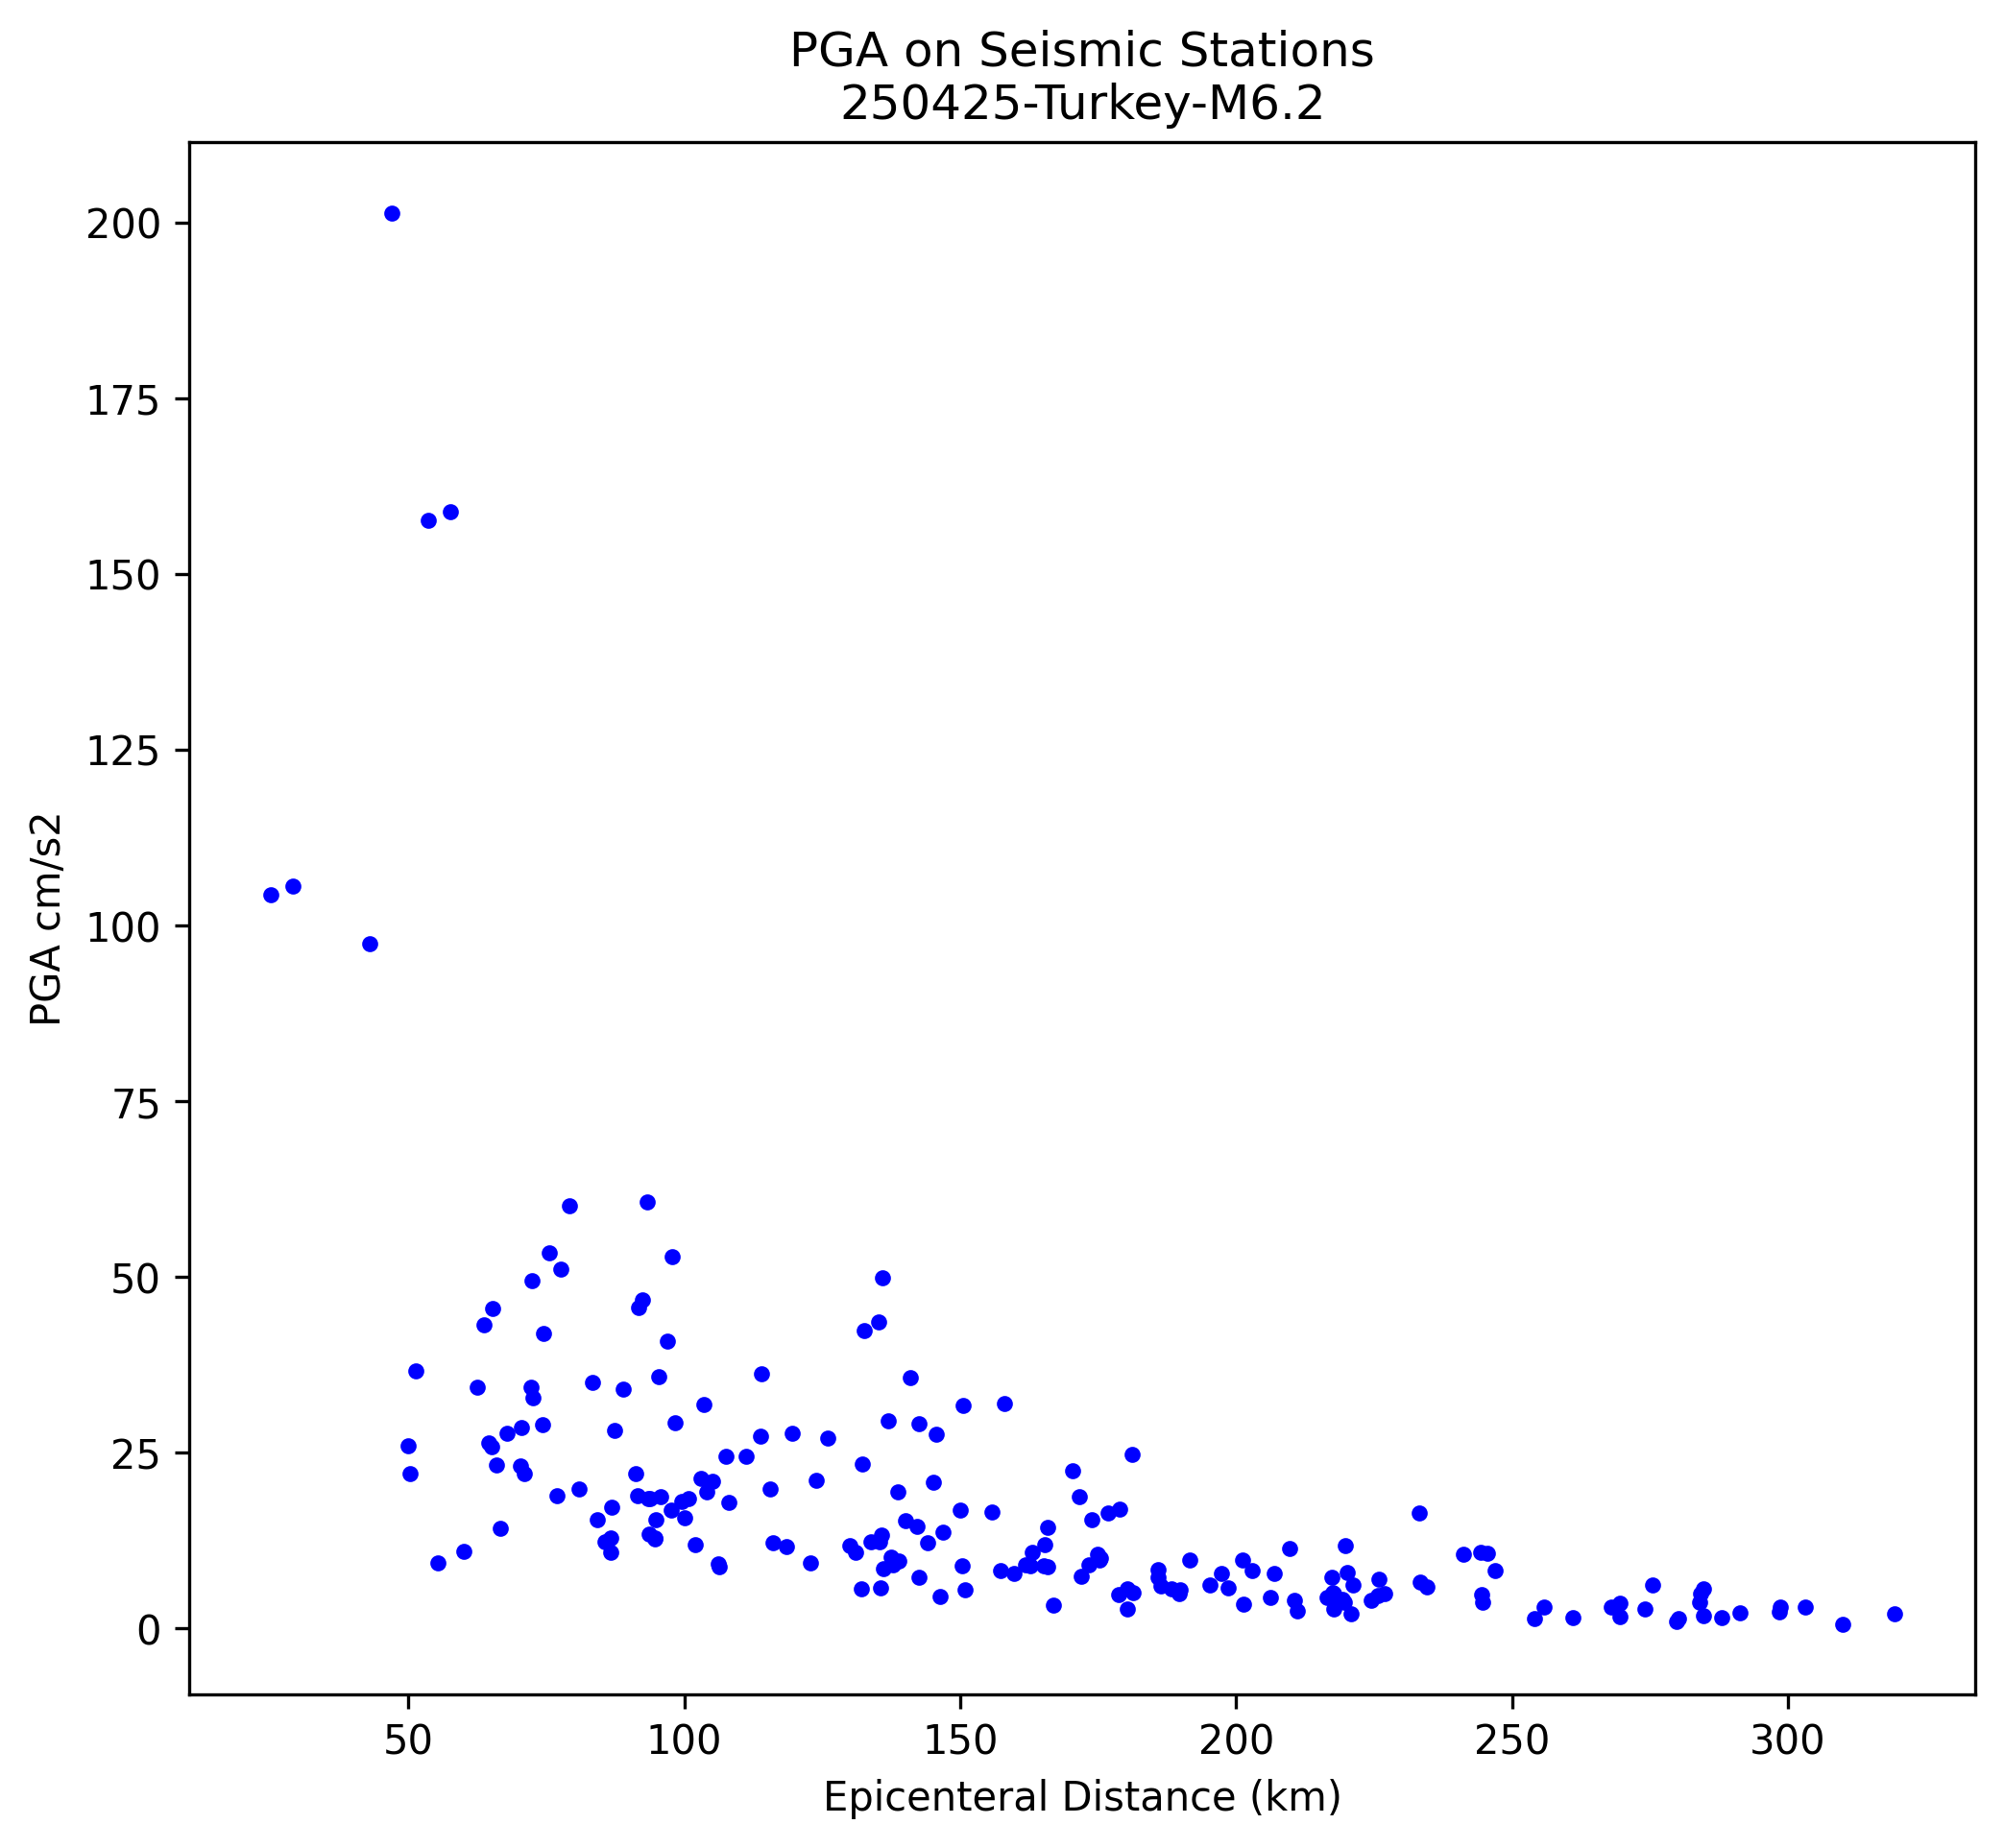

In [7]:
# PGA values (from station data) as function of distance
fig = plt.figure(figsize = (8,7), dpi=300)
ax = fig.add_subplot(1, 1, 1)

ax.plot(df_pga.epi_dist_km, df_pga.pga, 'bo', label = 'PGA', markersize=3)
ax.set_xlabel('Epicenteral Distance (km)')
ax.set_ylabel('PGA cm/s2')
ax.set_title('PGA on Seismic Stations\n' '250425-Turkey-M6.2')
plt.show()

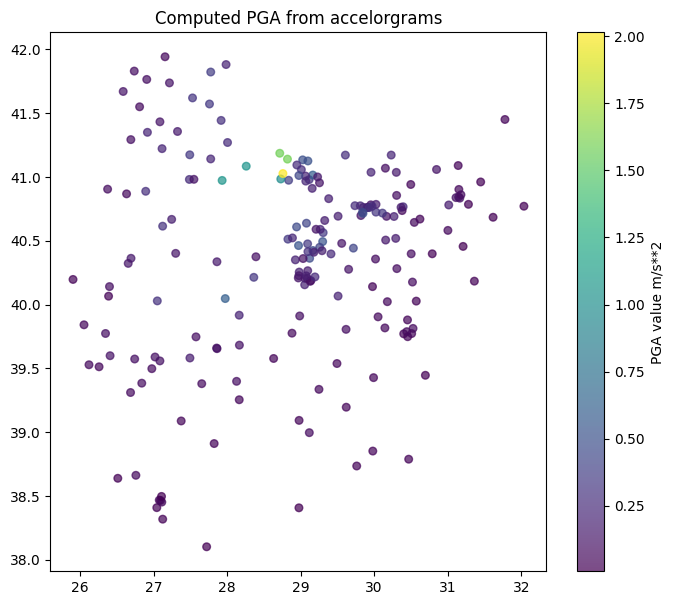

In [8]:
# PGA value (from station) map
BBox = (df_pga.lng.min(), df_pga.lng.max(),      
         df_pga.lat.min(), df_pga.lat.max())
fig = plt.figure(figsize = (8,7))
plt.scatter(df_pga.lng, df_pga.lat, zorder=1, alpha= 0.7, s=30, c=df_pga.pga/100) # marker="^"
c = plt.colorbar()
c.set_label("PGA value m/s**2")
plt.title("Computed PGA from accelorgrams")
plt.show()

@@@@ 5
3429 25.0424980156


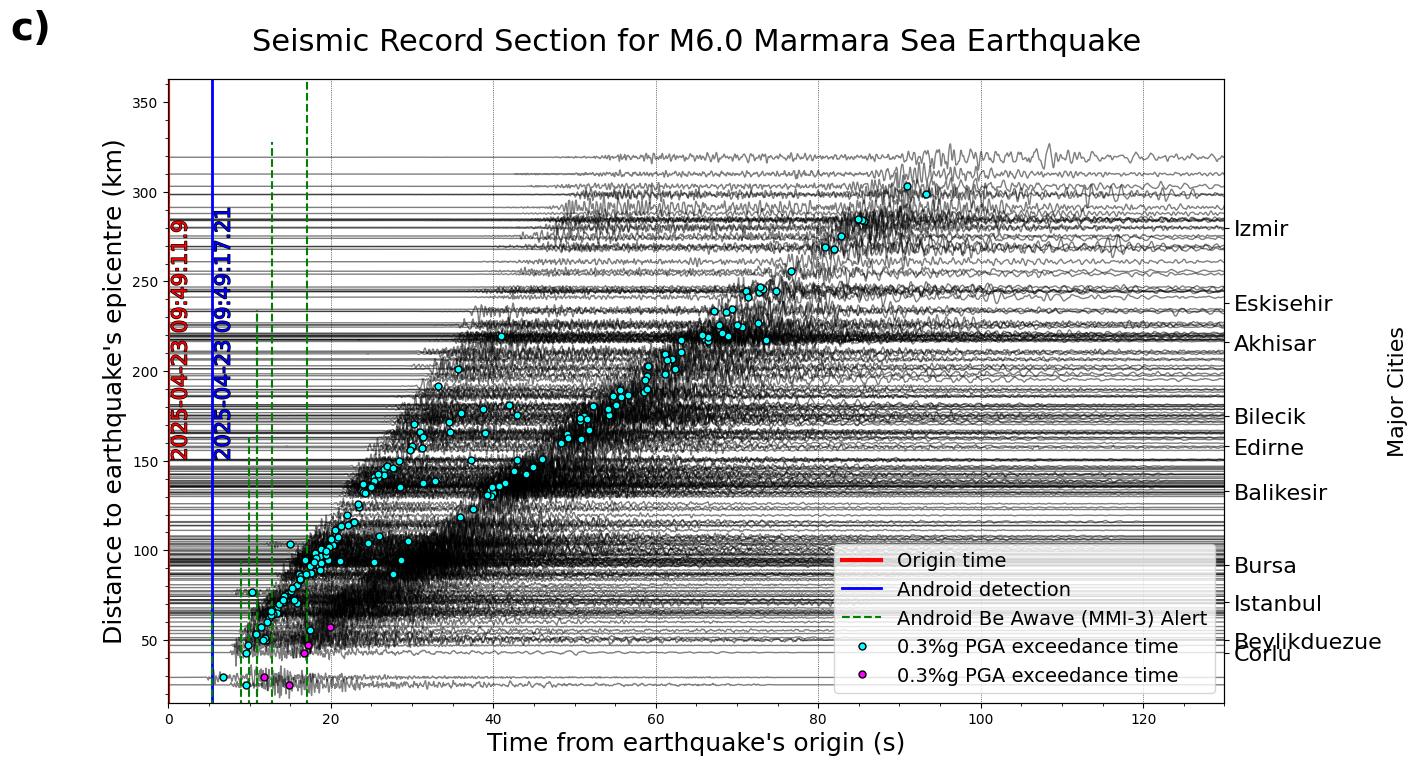

In [9]:
## This generates plot record sections for the station data
## annotated version is only get saved without display

station_proccessed_df = pd.read_csv('data_turkey_m6_25.csv')
all_z_data = glob.glob("./data_m6_4_25/data/*mseed")

start = UTCDateTime("2025-04-23T09:49:10.00")
end = UTCDateTime("2025-04-23T09:51:40.00")

TITLE_FONTSIZE = 22
AXIS_LABEL_FONTSIZE = 18
TICK_LABEL_FONTSIZE = 16
LEGEND_FONTSIZE = 14
ANNOTATION_FONTSIZE = 15
CORNER_LABEL_FONTSIZE = 28

from obspy import UTCDateTime

PGA_THRESHOLD_MMI3_cms2 = 2.91# for MMI3 0.297 %g
PGA_THRESHOLD_MMI5_cms2 = 60 # for MMI5 6.2 %g

dist_pga_time_mmi3 = []
dist_pga_time_mmi5 = []

for trdata in all_z_data:
    tr = read(trdata)
    all_channels_pga = []
    for i in range(3):
        station_code = tr[i].stats.station
        try:
            lng = station_proccessed_df[station_proccessed_df["Code"] == int(station_code)].Longitude.values[0]
            lat = station_proccessed_df[station_proccessed_df["Code"] == int(station_code)].Latitude.values[0]
            dist = station_proccessed_df[station_proccessed_df["Code"] == int(station_code)]["Repi"].values[0]
        except:
            lng = station_proccessed_df[station_proccessed_df["Code"] == station_code].Longitude.values[0]
            lat = station_proccessed_df[station_proccessed_df["Code"] == station_code].Latitude.values[0]
            dist = station_proccessed_df[station_proccessed_df["Code"] == station_code]["Repi"].values[0]
            
        tr[i].detrend("spline", order=3, dspline=500)
       # tr[i].filter("bandpass", freqmin = 0.5, freqmax = 5, corners=1, zerophase=True)
        tr.trim(start, end, pad=True, fill_value=0)
        passed_threshold = None
        for acc, time in zip(tr[i].data, tr[i].times()):
            if abs(acc) >= PGA_THRESHOLD_MMI3_cms2:
                passed_threshold = (abs(acc), float(time))
                break
        if passed_threshold:      
            all_channels_pga.append(passed_threshold)
    if len(all_channels_pga) >= 1: 
        pga_3c, pga_time = min(all_channels_pga, key=lambda item: item[1])
        dist_pga_time_mmi3.append((dist, pga_3c, pga_time))

for trdata in all_z_data:
    tr = read(trdata)
    all_channels_pga = []
    for i in range(3):
        station_code = tr[i].stats.station
        try:
            lng = station_proccessed_df[station_proccessed_df["Code"] == int(station_code)].Longitude.values[0]
            lat = station_proccessed_df[station_proccessed_df["Code"] == int(station_code)].Latitude.values[0]
            dist = station_proccessed_df[station_proccessed_df["Code"] == int(station_code)]["Repi"].values[0]
        except:
            lng = station_proccessed_df[station_proccessed_df["Code"] == station_code].Longitude.values[0]
            lat = station_proccessed_df[station_proccessed_df["Code"] == station_code].Latitude.values[0]
            dist = station_proccessed_df[station_proccessed_df["Code"] == station_code]["Repi"].values[0]
            
        tr[i].detrend("spline", order=3, dspline=500)
        tr[i].filter("bandpass", freqmin = 0.5, freqmax = 5, corners=1, zerophase=True)
        tr.trim(start, end, pad=True, fill_value=0)
        channel = tr[i].stats.channel
            
        passed_threshold = None
        for acc, time in zip(tr[i].data, tr[i].times()):
            if abs(acc) >= PGA_THRESHOLD_MMI5_cms2:
                passed_threshold = (abs(acc), float(time))
                break
        if passed_threshold:      
            all_channels_pga.append(passed_threshold)
    if len(all_channels_pga) >= 1: 
        pga_3c, pga_time = min(all_channels_pga, key=lambda item: item[1])
        dist_pga_time_mmi5.append((dist, pga_3c, pga_time))
print("@@@@", len(dist_pga_time_mmi5))
stream = Stream()

distances = []
station_names = []
all_waveforms = []

start = UTCDateTime("2025-04-23T09:49:11.9")
end = UTCDateTime("2025-04-23T09:51:40.00")

for trdata in all_z_data:
    tr = read(trdata)
    station_code = tr[0].stats.station

    try:
        lng = station_proccessed_df[station_proccessed_df["Code"] == int(station_code)].Longitude.values[0]
        lat = station_proccessed_df[station_proccessed_df["Code"] == int(station_code)].Latitude.values[0]
        dist = station_proccessed_df[station_proccessed_df["Code"] == int(station_code)]["Repi"].values[0]
    except:
        lng = station_proccessed_df[station_proccessed_df["Code"] == station_code].Longitude.values[0]
        lat = station_proccessed_df[station_proccessed_df["Code"] == station_code].Latitude.values[0]
        dist = station_proccessed_df[station_proccessed_df["Code"] == station_code]["Repi"].values[0]

    distances.append(dist)
    station_names.append(station_code)
    
    
    for i in range(3):
        if len(tr[i].data) > 10000 and tr[i].stats.sampling_rate == 100:
            st = tr[i].stats.starttime
            et = tr[i].stats.endtime
            channel = tr[i].stats.channel

            tr[i].detrend("spline", order=3, dspline=500)
            tr[i].filter("bandpass", freqmin = 0.5, freqmax = 5, corners=1, zerophase=True)
            tr[i].stats["latitude"] = lat
            tr[i].stats["longitude"] = lng
            tr[i].stats["distance"] = dist*1000
    
        if channel == "Z" and len(tr[i].data) > 10000: 
            tr.trim(start, end, pad=True, fill_value=0)
            all_waveforms.append(tr[i].data)
            stream +=tr[i]

closest_station = min(distances)
print(station_names[distances.index(closest_station)], closest_station)

fig = plt.figure(figsize=(12, 8))
stream.plot(outfile='recordsection_h_turky_M6_04_25.png', type='section',offset_max=350*1000, scale=7, orientation='horizontal', fig=fig)
stream.plot(outfile='recordsection_v_turky_M6_04_25.png', type='section',offset_max=350*1000, scale=7, orientation='vertical', linewidth=0.7)

edge_effect = [path_effects.withStroke(linewidth=1, foreground='black')]
# Axis of the plot
ax = fig.axes[0]

# --- 2. Add Vertical Lines and Store Them ---
origin_time_xval = 0  # Define the x-value for origin time
eqn_detection_xval = 5.31 # Define the x-value for android detection

origin_color = 'red'
aea_color = 'blue'
line_origin = ax.axvline(origin_time_xval, color=origin_color, linestyle='-', 
                         linewidth=3, label='Origin time', markeredgecolor='k')
line_aea = ax.axvline(eqn_detection_xval, color=aea_color, linestyle='-', 
                      linewidth=2, label='Android detection', path_effects=edge_effect)

ax.plot([5.31, 5.31], [0, 70],
        color='green',      # Choose your color
        linestyle='--',    # Choose your linestyle
        linewidth=1.5,      # Choose your linewidth
        label='Android Be Awave (MMI-3) Alert') # Add a label for the legend
ax.plot([8.94 , 8.94 ], [0, 94],
        color='green',      # Choose your color
        linestyle='--',    # Choose your linestyle
        linewidth=1.5,      # Choose your linewidth
        label="_nolegend_") # Add a label for the legend
ax.plot([9.87, 9.87], [0, 163],
        color='green',      # Choose your color
        linestyle='--',    # Choose your linestyle
        linewidth=1.5,      # Choose your linewidth
        label="_nolegend_") # Add a label for the legend
ax.plot([10.89 , 10.89], [0, 234],
        color='green',      # Choose your color
        linestyle='--',    # Choose your linestyle
        linewidth=1.5,      # Choose your linewidth
        label="_nolegend_") # Add a label for the legend
ax.plot([10.89, 10.89], [0, 234],
        color='green',      # Choose your color
        linestyle='--',    # Choose your linestyle
        linewidth=1.5,      # Choose your linewidth
        label="_nolegend_") # Add a label for the legend
ax.plot([12.71, 12.71], [0, 328],
        color='green',      # Choose your color
        linestyle='--',    # Choose your linestyle
        linewidth=1.5,      # Choose your linewidth
        label="_nolegend_") # Add a label for the legend
ax.plot([17.12, 17.12], [0, 365],
        color='green',      # Choose your color
        linestyle='--',    # Choose your linestyle
        linewidth=1.5,      # Choose your linewidth
        label="_nolegend_") # Add a label for the legend

x_text_offset = 1.5  # Offset from the line in data units (e.g., seconds). Adjust as needed.
fontsize_text = 9
y_pos_for_text = 150

# Text for the Origin Line
ax.text(origin_time_xval + x_text_offset,
         y_pos_for_text, 
         '2025-04-23 09:49:11.9',
         rotation=90,
         va='bottom',
         ha='center',
         color=line_origin.get_color(), # Match line color
         fontsize=ANNOTATION_FONTSIZE,
        path_effects=edge_effect)

# Text for the EQN Detection Line
ax.text(eqn_detection_xval + x_text_offset,
         y_pos_for_text,
         '2025-04-23 09:49:17.21', # Get label from the line object
         rotation=90,
         va='bottom',
         ha='center',
         color=line_aea.get_color(), # Match line color
         fontsize=ANNOTATION_FONTSIZE,
        path_effects=edge_effect)

# Adding PGA-Intensity markers
i = 0
for dist_km, _, time_s in dist_pga_time_mmi3:
    ax.plot(time_s, dist_km, 'o', color='cyan', markersize=5, linewidth=0.01,
            markerfacecolor='cyan', markeredgecolor='k',
            label="0.3%g PGA exceedance time" if i == 0 else "_nolegend_")
    i += 1

i = 0
for dist_km, _, time_s in dist_pga_time_mmi5:
    ax.plot(time_s, dist_km, 'o', 
            color='magenta',  # <-- Changed
            markersize=5, 
            linewidth=0.01,
            markerfacecolor='magenta',  # <-- Changed
            markeredgecolor='k',
            label="0.3%g PGA exceedance time" if i == 0 else "_nolegend_")
    i += 1

    
# --- 4. Configure Primary Y-Axis (Left - Distances) ---
distances = [dist for dist, _, _ in dist_pga_time_mmi3]
ax.set_ylabel("Distance to earthquake's epicentre (km)", fontsize=AXIS_LABEL_FONTSIZE)
ax.set_ylim(min(distances) - 10, max(distances) + 60) # Add some padding
ax.set_xlim(0, 130) # Add some padding

# --- 5. Configure X-Axis (Bottom - Time) ---
ax.set_xlabel(f"Time from earthquake's origin (s)", fontsize=AXIS_LABEL_FONTSIZE)

    
# --- 6. Configure Secondary Y-Axis (Right - Station Names) ---
new_right_tick_positions = [71, 50, 92, 133, 238, 280, 158, 216, 175, 43]
new_right_tick_labels = ['Istanbul', 'Beylikduezue', 'Bursa', 'Balikesir', 
                         'Eskisehir', 'Izmir', 'Edirne', 'Akhisar', 'Bilecik',
                         'Corlu']

ax2 = ax.twinx()
ax2.set_ylabel('Major Cities', fontsize=TICK_LABEL_FONTSIZE)
ax2.set_ylim(ax.get_ylim()) # Match the limits of the first y-axis
ax2.set_yticks(new_right_tick_positions)
ax2.set_yticklabels(new_right_tick_labels)
ax2.tick_params(axis='y', which='major', labelsize=TICK_LABEL_FONTSIZE)

# --- 7. Add Legend and Title ---
# Collect handles and labels for the legend
handles, labels = [], []
# Add from ax1
h_ax1, l_ax1 = ax.get_legend_handles_labels()
handles.extend(h_ax1)
labels.extend(l_ax1)

ax.legend(handles=handles, loc='lower right', frameon=True, fontsize=LEGEND_FONTSIZE)
ax.set_title('Seismic Record Section for M6.0 Marmara Sea Earthquake', fontsize=TITLE_FONTSIZE, pad=20) # <-- ADDED
ax.text(-0.15, 1.05, 'c)', transform=ax.transAxes, fontsize=CORNER_LABEL_FONTSIZE, fontweight='bold', va='bottom', ha='left')
plt.show()

fig.subplots_adjust(left=0.12, right=0.85, top=0.9, bottom=0.12)

fig.savefig('annotated_station_plot_record_section_m6_turkey_3.png',dpi=500, bbox_inches='tight')

In [11]:
proccessed_station_df = pd.read_csv('data_turkey_m6_25.csv')
print(proccessed_station_df.keys())
print(proccessed_station_df[proccessed_station_df.Code == "KURT"])

Index(['Code', 'Longitude', 'Latitude', 'Province', 'District', 'PGA_NS',
       'PGA_EW', 'PGA_UD', 'Rjb', 'Rrup', 'Repi', 'Rhyp'],
      dtype='object')
    Code  Longitude  Latitude Province       District     PGA_NS     PGA_EW  \
36  KURT    29.2092   40.5905   Yalova  Yalova Merkez  11.945957  12.990494   

      PGA_UD       Rjb       Rrup       Repi     Rhyp  
36  6.655984  82.63209  82.677374  86.645604  86.9215  


In [13]:
print(proccessed_station_df.keys())
for repi in sorted(proccessed_station_df.Repi.tolist())[:5]:
    print(proccessed_station_df[proccessed_station_df.Repi == repi].Code.to_string(), repi)

Index(['Code', 'Longitude', 'Latitude', 'Province', 'District', 'PGA_NS',
       'PGA_EW', 'PGA_UD', 'Rjb', 'Rrup', 'Repi', 'Rhyp'],
      dtype='object')
0    3429 25.0424980156
1    5906 29.1505290055
2    3428 43.0506357446
3    3415 47.0117112588
4    5917 49.8627614421
